In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

/root/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 32
input_size = 13
output_size = 1
hidden_size = 8
num_layers = 1
num_classes = 1
num_epochs = 100

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## 1. 准备数据

In [4]:
import pandas as pd
import numpy as np
data_df = pd.read_csv('./data/boston.csv', index_col=[0])

In [5]:
data_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [6]:
X = data_df.iloc[:, :-1]
y = data_df.iloc[:, -1]

In [7]:
'''
X = np.expand_dims(X, axis=1)
y = np.expand_dims(y, axis=1)
y = np.expand_dims(y, axis=1)
'''
# y = np.expand_dims(y, axis=1)

'\nX = np.expand_dims(X, axis=1)\ny = np.expand_dims(y, axis=1)\ny = np.expand_dims(y, axis=1)\n'

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [9]:
X_train.shape

(404, 13)

In [10]:
# 将数据转换为张量并放入数据加载器
X_train_tensor = torch.from_numpy(X_train.values).float()
y_train_tensor = torch.from_numpy(y_train.values).float()
X_test_tensor = torch.from_numpy(X_test.values).float()
y_test_tensor = torch.from_numpy(y_test.values).float()

In [11]:
X_train_tensor.shape

torch.Size([404, 13])

In [12]:
# 定义数据集
class BostonDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
# 创建数据集对象
train_dataset = BostonDataset(X_train_tensor, y_train_tensor)
test_dataset = BostonDataset(X_test_tensor, y_test_tensor)

In [14]:
# 创建数据加载器
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## 2. LSTM模型

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [16]:
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

## 3. 定义损失函数和优化器

In [17]:
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## 4. 训练模型

In [ ]:
Loss = []

In [26]:
for epoch in range(1000):
    for i, (X, y) in enumerate(train_dataloader):
        #X = torch.from_numpy(X).float().to(device); y = torch.from_numpy(y).float().to(device)
        X = X.view(-1, 1, 13).float().to(device); y = y.float().to(device)
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)
        Loss.append(loss.tolist())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
   
    if (epoch+1) % 20 == 0:
        
        with torch.no_grad():
            for X, y in train_dataloader:
                X = X.view(-1, 1, 13).float().to(device); y = y.float().to(device)

                outputs = model(X)
                
                # print(f'Prediction: {outputs.data.numpy()}')
                # print(f'Ground Truth: {y.numpy()}')
                # 计算结果的均方差
                mse = ((outputs - y) ** 2).mean()
                print(f'Mean Squared Error: {mse.item():.4f}')
            
        print('Epoch [{}/{}], MSE: {:.4f},  Loss: {:.4f}'.format(epoch+1, num_epochs, mse.item(), loss.item()))

Mean Squared Error: 90.7446
Mean Squared Error: 51.8450
Mean Squared Error: 106.2404
Mean Squared Error: 85.1982
Mean Squared Error: 127.0038
Mean Squared Error: 136.2650
Mean Squared Error: 36.6147
Mean Squared Error: 85.6039
Mean Squared Error: 94.3433
Mean Squared Error: 103.7873
Mean Squared Error: 85.4727
Mean Squared Error: 60.7501
Mean Squared Error: 52.6529
Epoch [20/100], MSE: 52.6529,  Loss: 86.8073
Mean Squared Error: 90.6986
Mean Squared Error: 61.0938
Mean Squared Error: 72.0605
Mean Squared Error: 43.5900
Mean Squared Error: 135.5604
Mean Squared Error: 84.5999
Mean Squared Error: 92.9763
Mean Squared Error: 70.1569
Mean Squared Error: 93.1894
Mean Squared Error: 102.4941
Mean Squared Error: 77.9415
Mean Squared Error: 146.5585
Mean Squared Error: 41.3774
Epoch [40/100], MSE: 41.3774,  Loss: 74.6583
Mean Squared Error: 102.0084
Mean Squared Error: 67.4057
Mean Squared Error: 95.7209
Mean Squared Error: 56.4778
Mean Squared Error: 67.6513
Mean Squared Error: 103.4342
Mean 

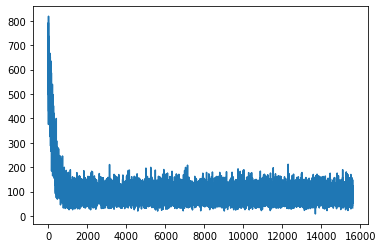

In [27]:
import matplotlib.pyplot as plt
plt.plot(Loss)

## 5. 模型评估

In [22]:
# 模型评估
y_pred = []
with torch.no_grad():
    for i, (X, y) in enumerate(test_dataloader):
        X = X.view(-1, 1, 13).float().to(device); y = y.float().to(device)

        outputs = model(X)
        

            
        print(f'Prediction: {outputs.data.numpy()}')
        print(f'Ground Truth: {y.numpy()}')
        # 计算结果的均方差
        mse = ((outputs - y) ** 2).mean()
        print(f'Mean Squared Error: {mse.item():.4f}')
                

Prediction: [[22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]]
Ground Truth: [15.2 25.  22.4 29.8 16.1 26.5 14.1 29.  22.5 20.8 22.8 34.7 21.4 32.4
 22.6 14.  20.  29.1 20.9 10.2 10.4 20.3 24.1 19.9 24.  19.4 19.1 23.
 24.4 25.2 20.  16.8]
Mean Squared Error: 32.1614
Prediction: [[22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [22.086926]
 [2

> 在 PyTorch 中，损失函数和神经网络的输出通常都是浮点数，而标签一般是整数。所以在这里，我们需要将标签数据转换为 `long` 类型。
>
> 需要注意的是在 Pytorch 中，long 类型是 `int64`，而在 Numpy 中，`int64` 是 `int32`,这可能导致一些错误。 所以通常我们使用 `.long()` 来将numpy `int64` 转为 torch `int64`,防止报错